In [34]:
# 1. Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [35]:
# 2. Load dataset
df = pd.read_csv("sentimentdataset.csv")

In [36]:
# 3. Simplify Sentiment
def simplify_sentiment(sent):
    s = str(sent).lower()
    if any(word in s for word in ["pos", "good", "great", "happy", "love", "joy", "wonderful", "excellent"]):
        return "Positive"
    elif any(word in s for word in ["neg", "bad", "sad", "angry", "hate", "terrible", "poor", "worst"]):
        return "Negative"
    else:
        return "Neutral"

df["Sentiment_Simplified"] = df["Sentiment"].apply(simplify_sentiment)
print("\nSimplified sentiment distribution before balancing:")
print(df["Sentiment_Simplified"].value_counts())


Simplified sentiment distribution before balancing:
Sentiment_Simplified
Neutral     590
Positive    115
Negative     27
Name: count, dtype: int64


In [37]:
# 4. Oversample for balance
neutral_df = df[df["Sentiment_Simplified"] == "Neutral"]
positive_df = df[df["Sentiment_Simplified"] == "Positive"]
negative_df = df[df["Sentiment_Simplified"] == "Negative"]

max_size = max(len(neutral_df), len(positive_df), len(negative_df))
positive_upsampled = resample(positive_df, replace=True, n_samples=max_size, random_state=42)
negative_upsampled = resample(negative_df, replace=True, n_samples=max_size, random_state=42)
neutral_upsampled  = resample(neutral_df, replace=True, n_samples=max_size, random_state=42)

df_balanced = pd.concat([positive_upsampled, negative_upsampled, neutral_upsampled])
print("\nSimplified sentiment distribution after balancing:")
print(df_balanced["Sentiment_Simplified"].value_counts())


Simplified sentiment distribution after balancing:
Sentiment_Simplified
Positive    590
Negative    590
Neutral     590
Name: count, dtype: int64


In [38]:
# 5. Features + Labels
X = df_balanced[["Likes", "Retweets", "Hour", "Day", "Month"]].values
le = LabelEncoder()
y = le.fit_transform(df_balanced["Sentiment_Simplified"])

In [39]:
# 6. Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# 7. Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
# 8. Train KNN model (k=5 default)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [42]:
# 9. Predict
y_pred = knn.predict(X_test)

In [43]:
# 10. Evaluate
print("\nModel Evaluation (After Balancing):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Model Evaluation (After Balancing):
Accuracy: 0.8813559322033898

Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      1.00      0.95       119
     Neutral       0.90      0.75      0.82       113
    Positive       0.84      0.89      0.86       122

    accuracy                           0.88       354
   macro avg       0.88      0.88      0.88       354
weighted avg       0.88      0.88      0.88       354


Confusion Matrix:
 [[119   0   0]
 [  7  85  21]
 [  5   9 108]]


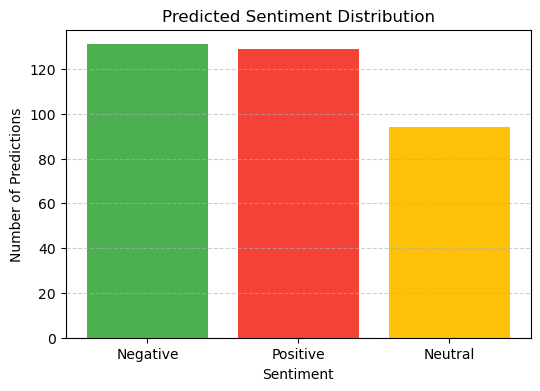

In [44]:
# VISUALIZATION 1: Bar Chart of Predicted Sentiment Counts
# ============================================================
pred_counts = pd.Series(y_pred).value_counts()
pred_labels = [le.classes_[i] for i in pred_counts.index]

plt.figure(figsize=(6,4))
plt.bar(pred_labels, pred_counts.values, color=['#4CAF50', '#F44336', '#FFC107'])
plt.title("Predicted Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Predictions")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

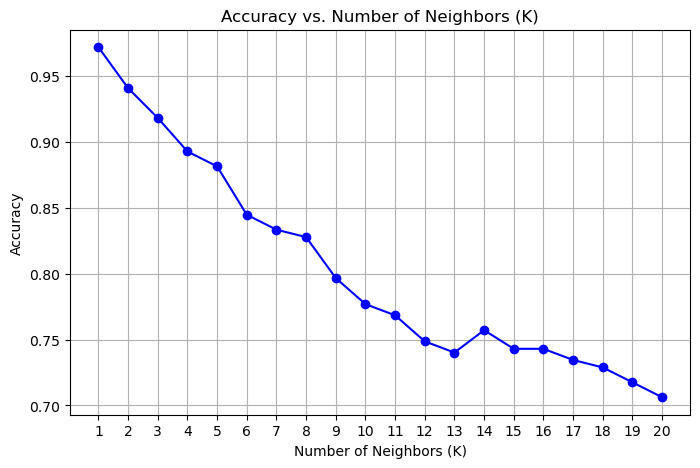


Best K value based on this test range: 1 (Accuracy = 0.972)


In [45]:
# VISUALIZATION 2: Accuracy vs. K Plot

k_values = list(range(1, 21))
accuracies = []

for k in k_values:
    model_k = KNeighborsClassifier(n_neighbors=k)
    model_k.fit(X_train, y_train)
    acc = accuracy_score(y_test, model_k.predict(X_test))
    accuracies.append(acc)

plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title("Accuracy vs. Number of Neighbors (K)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.show()

best_k = k_values[accuracies.index(max(accuracies))]
print(f"\nBest K value based on this test range: {best_k} (Accuracy = {max(accuracies):.3f})")